<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Neural_Network_Base_Model_separate_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 8.1 MB/s 


In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit
from sklearn.metrics import confusion_matrix

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)

train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# trim start stage
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

In [13]:
train_df.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

In [14]:
P1 = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102']
P2 = ['AIT201', 'AIT202','AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206']
P3 = ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302']
P4 = ['AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401']
P5 = ['AIT501', 'AIT502', 'AIT503', 'AIT504','FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503']
P6 = ['FIT601', 'P601', 'P602', 'P603']

Model Prediction on each stage

In [28]:
from  pyod.models.deep_svdd import DeepSVDD
model = DeepSVDD(preprocessing = False,epochs=100, batch_size=64, hidden_neurons=[64, 32])

In [29]:
def get_test_score(stage,train_scale,test_scale):
  norm_test_scores = []
  test_scores = []
  train_scores = []
  norm_train_scores = []
  trainning_time = []
  prediction_time = []

  for i in stage:
    start = timeit.default_timer()
    model.fit(train_scale[i])
    end = timeit.default_timer()

    train_score = model.decision_scores_
    start_pred = timeit.default_timer()
    test_score = model.decision_function(test_scale[i])
    end_pred = timeit.default_timer()

    test_scores.append(test_score)
    train_scores.append(train_score)

    trainning_time.append(end-start)
    prediction_time.append(end_pred-start_pred)

    #normalise train&test score
    min_train = min(train_score)
    max_train = max(train_score)
    norm_train = (train_score-min_train)/(max_train-min_train)
    norm_test = (test_score - min_train)/(max_train-min_train)

    norm_test_scores.append(norm_test)
    norm_train_scores.append(norm_train)

    print(f"------ Finish Stage {i} ------")
  return norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time


In [30]:
stage = [P1,P2,P3,P4,P5,P6]

In [31]:
norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time = get_test_score(stage,train_scale,test_scale)

14850/14850 [==============================] - 14s 946us/step
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_15 (Dense)            (None, 64)                320       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_15 (TFOpLa  (None, 32)               0         
 mbda)                                                           
                                                                 
 tf.math.pow_15 (TFOpLambda)  (None, 32)               0         
                                                                 
 tf.math.reduce_sum_15 (TFOp  (None,)                  0      

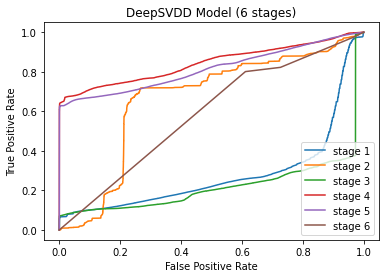

In [32]:
aucs = []
for i in range(len(norm_test_scores)):
  fpr, tpr, _ = metrics.roc_curve(label,  test_scores[i])
  auc = metrics.roc_auc_score(label,  test_scores[i])
  aucs.append(auc)
  plt.plot(fpr,tpr,label=f"stage {i+1}")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(f'DeepSVDD Model (6 stages)')
  plt.legend(loc=4)

In [26]:
for i in range(len(aucs)):
  print(f"AUC stage{i+1}: {np.round(aucs[i],3)}, training time = {trainning_time[i]}, prediction_time = {prediction_time[i]}")

AUC stage1: 0.256, training time = 754.0938470299999, prediction_time = 19.08656433400006
AUC stage2: 0.645, training time = 752.5082146669997, prediction_time = 18.712585086999752
AUC stage3: 0.214, training time = 752.4641861119999, prediction_time = 19.143767488999856
AUC stage4: 0.849, training time = 770.7710353430002, prediction_time = 19.05685766200031
AUC stage5: 0.813, training time = 770.4863341070004, prediction_time = 19.104129039000327
AUC stage6: 0.587, training time = 781.5430193299999, prediction_time = 19.074669761000223


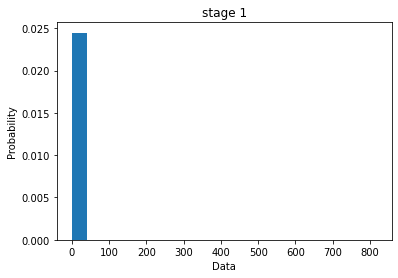

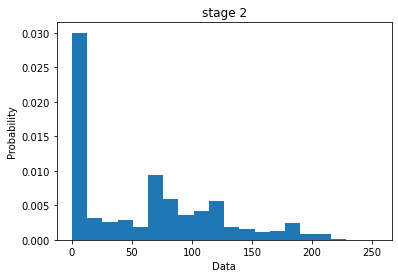

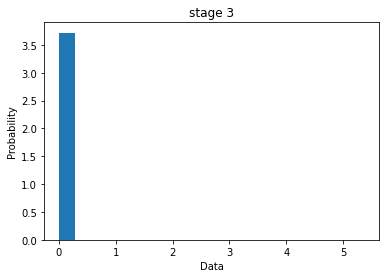

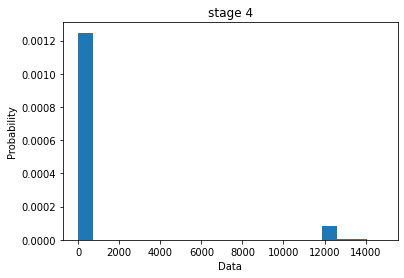

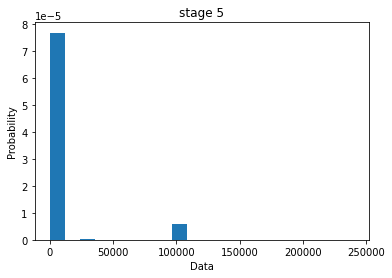

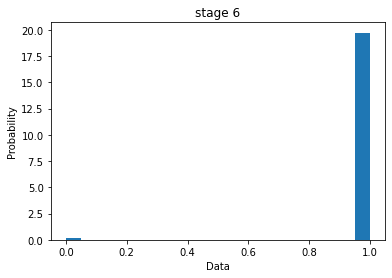

In [34]:
for i in range(len(norm_test_scores)):
  plt.hist(norm_test_scores[i], density=True, bins=20)  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')
  plt.title(f'stage {i+1}')
  plt.show()

In [35]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
    else:
      pred_label[i:i+time_window] = 0

  return pred_label

In [36]:
time_window = 10

##Ture Attack point

In [37]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [38]:
true_attack = true_anomaly[~true_anomaly["End Time"].isnull()]

In [39]:
true_attack.tail(3)

,Attack #,Start Time,End Time,Attack Point,Start State,Attack,Actual Change,Expected Impact or attacker intent,Unexpected Outcome
38,39,2/01/2015 11:43:48,11:50:28,"FIT-401, AIT-502",In Normal Range,Set value of FIT-401 as 0.5; Set value of AIT-...,No,UV will shut down and water will go to RO,UV did not shutdown
39,40,2/01/2015 11:51:42,11:56:38,FIT-401,In Normal Range,Set value of FIT-401 as 0,No,UV will shut down and water will go to RO,"P-402 did not close, both should be interlinked"
40,41,2/01/2015 13:13:02,13:40:56,LIT-301,Water level between L and H,decrease value by 0.5 mm per second,No,Tank overflow,Rate of decrease in water level reduced after ...


In [41]:
start_time = true_attack['Start Time']
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [42]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [43]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [44]:
len(start_time) #there are 36 attack

36

In [45]:
start_time.index.values+1

array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41])

In [46]:
time_label = pd.DataFrame(label, index =  test_df.index.values, columns = ["label"])
time_label.reset_index(inplace=True)
time_label.rename(columns = {'index':'Timestamp'}, inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label['Timestamp'])

In [47]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [48]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]+1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##tunning threshold from stage P1

In [49]:
!pip install ghostml --quiet

In [201]:
import ghostml
n_percentile = [np.percentile(norm_test_scores,i) for i in range(90,100,1)]

In [202]:
threshold1 = ghostml.optimize_threshold_from_predictions(label, norm_test_scores[0], n_percentile, ThOpt_metrics = 'Kappa') 

In [203]:
threshold1

12228.621914062496

In [204]:
n_percentile #percentil 98

[72.06639709472658,
 75.36902618408203,
 82.9017105102539,
 95.04184577941896,
 107.76766937255826,
 123.26888542175321,
 148.8320770263672,
 187.67132568359375,
 12228.621914062496,
 102298.8359375]

##Stage P1

In [147]:
t1 = np.percentile(norm_test_scores[0],98)

In [148]:
label_1 = pred_labels_timewindow(norm_test_scores[0],t1,time_window)

In [149]:
time_label["pred_1"] = label_1

In [150]:
att_p1 = time_label[time_label['attack #'].isin([1,2,3,21,26,30,33,34,35,36])]

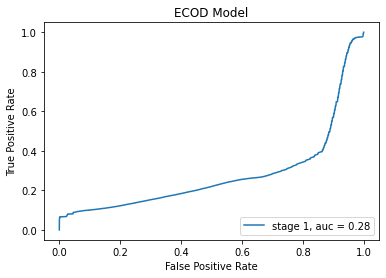

In [151]:
fpr, tpr, _ = metrics.roc_curve(label, norm_test_scores[0])
auc = metrics.roc_auc_score(label, norm_test_scores[0])
plt.plot(fpr,tpr,label=f"stage 1, auc = {np.round(auc,2)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ECOD Model')
plt.legend(loc=4)

In [152]:
print(metrics.classification_report(label,label_1))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93    395298
           1       0.37      0.07      0.11     54621

    accuracy                           0.87    449919
   macro avg       0.63      0.53      0.52    449919
weighted avg       0.82      0.87      0.83    449919



[[388985   6313]
 [ 50920   3701]]


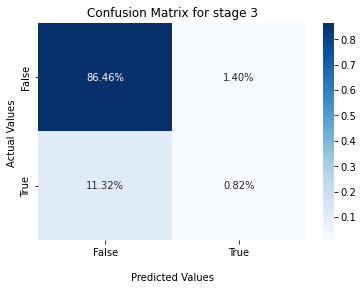

In [153]:
cm = confusion_matrix(label,label_1)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [154]:
print(metrics.classification_report(att_p1.label,att_p1.pred_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.55      0.71      6669

    accuracy                           0.55      6669
   macro avg       0.50      0.28      0.36      6669
weighted avg       1.00      0.55      0.71      6669



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
found = []
for i in range(len(att_p1)):
  if (att_p1.iloc[i]["pred_1"] == 1) & (att_p1.iloc[i]["label"] == 1):
    found.append(att_p1.iloc[i]["attack #"])
print(np.unique(found))

[ 1  2  3 26 30 33 34 36]


In [156]:
np.unique(att_p1["attack #"])

array([ 1,  2,  3, 21, 26, 30, 33, 34, 35, 36])

##Stage P2

In [157]:
t2 = np.percentile(norm_test_scores[1],98)

In [158]:
t2

194.08807373046875

In [159]:
label_2 = pred_labels_timewindow(norm_test_scores[1],t2,time_window)

In [160]:
print(metrics.classification_report(label,label_2))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92    395298
           1       0.05      0.01      0.02     54621

    accuracy                           0.86    449919
   macro avg       0.47      0.49      0.47    449919
weighted avg       0.78      0.86      0.81    449919



[[386476   8822]
 [ 54124    497]]


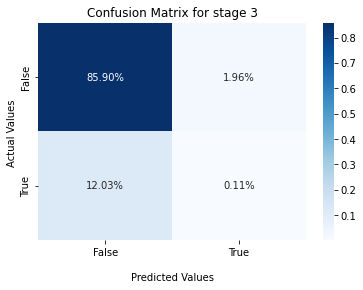

In [161]:
cm = confusion_matrix(label,label_2)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [162]:
time_label["pred_2"] = label_2

In [163]:
att_p2 = time_label[time_label['attack #'].isin([6,24,29])]

In [164]:
found = []
for i in range(len(att_p2)):
  if (att_p2.iloc[i]["pred_2"] == 1) & (att_p2.iloc[i]["label"] == 1):
    found.append(att_p2.iloc[i]["attack #"])
print(np.unique(found))

[]


In [165]:
print(metrics.classification_report(att_p2.label,att_p2.pred_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     638.0

    accuracy                           0.00     638.0
   macro avg       0.00      0.00      0.00     638.0
weighted avg       0.00      0.00      0.00     638.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

##Stage P3

In [166]:
t3 = np.percentile(norm_test_scores[2],98)

In [167]:
t3

0.055382704734802245

In [168]:
label_3 = pred_labels_timewindow(norm_test_scores[2],t3,time_window)

In [169]:
print(metrics.classification_report(label,label_3))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93    395298
           1       0.33      0.08      0.13     54621

    accuracy                           0.87    449919
   macro avg       0.61      0.53      0.53    449919
weighted avg       0.82      0.87      0.83    449919



[[386604   8694]
 [ 50260   4361]]


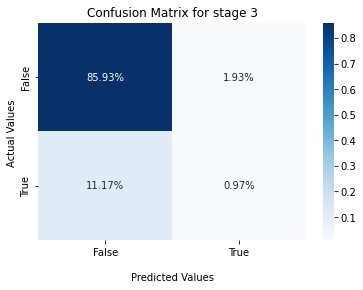

In [170]:
cm = confusion_matrix(label,label_3)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [171]:
time_label["pred_3"] = label_3

In [172]:
att_p3 = time_label[time_label['attack #'].isin([7,8,13,14,16,17,23,26,27,28,32,41])]

In [173]:
found = []
for i in range(len(att_p3)):
  if (att_p3.iloc[i]["pred_3"] == 1) & (att_p3.iloc[i]["label"] == 1):
    found.append(att_p3.iloc[i]["attack #"])
print(np.unique(found))

[ 7  8 14 16 23 26 27 28 32 41]


In [174]:
print(metrics.classification_report(att_p3.label,att_p3.pred_3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.09      0.17     43368

    accuracy                           0.09     43368
   macro avg       0.50      0.05      0.09     43368
weighted avg       1.00      0.09      0.17     43368



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Stage P4

In [175]:
t4 = np.percentile(norm_test_scores[3],98)

In [176]:
t4

12286.732890625

In [177]:
label_4 = pred_labels_timewindow(norm_test_scores[3],t4,time_window)

In [178]:
print(metrics.classification_report(label,label_4))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95    395298
           1       0.99      0.17      0.29     54621

    accuracy                           0.90    449919
   macro avg       0.94      0.58      0.62    449919
weighted avg       0.91      0.90      0.87    449919



[[395233     65]
 [ 45533   9088]]


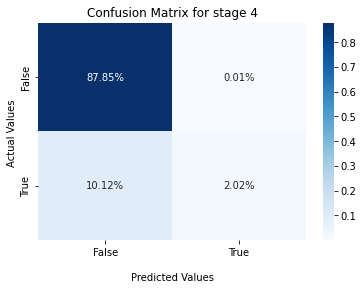

In [180]:
cm = confusion_matrix(label,label_4)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 4');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [181]:
time_label["pred_4"] = label_4

In [182]:
att_p4 = time_label[time_label['attack #'].isin([10,11,22,25,31,38,39,40])]

In [183]:
found = []
for i in range(len(att_p4)):
  if (att_p4.iloc[i]["pred_4"] == 1) & (att_p4.iloc[i]["label"] == 1):
    found.append(att_p4.iloc[i]["attack #"])
print(np.unique(found))

[11]


In [184]:
print(metrics.classification_report(att_p4.label,att_p4.pred_4))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.00      0.01      3142

    accuracy                           0.00      3142
   macro avg       0.50      0.00      0.00      3142
weighted avg       1.00      0.00      0.01      3142



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Stage P5

In [185]:
t5 = np.percentile(norm_test_scores[4],98)

In [186]:
t5

103064.765625

In [187]:
label_5 = pred_labels_timewindow(norm_test_scores[4],t5,time_window)

In [188]:
print(metrics.classification_report(label,label_5))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95    395298
           1       0.99      0.17      0.29     54621

    accuracy                           0.90    449919
   macro avg       0.94      0.58      0.62    449919
weighted avg       0.91      0.90      0.87    449919



[[395194    104]
 [ 45348   9273]]


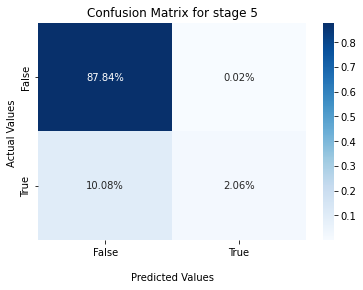

In [189]:
cm = confusion_matrix(label,label_5)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 5');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [190]:
time_label["pred_5"] = label_5

In [191]:
att_p5 = time_label[time_label['attack #'].isin([4,19,20,22,37,38,39])]

In [192]:
found = []
for i in range(len(att_p5)):
  if (att_p5.iloc[i]["pred_5"] == 1) & (att_p5.iloc[i]["label"] == 1):
    found.append(att_p5.iloc[i]["attack #"])
print(np.unique(found))

[]


In [193]:
print(metrics.classification_report(att_p5.label,att_p5.pred_5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    2658.0

    accuracy                           0.00    2658.0
   macro avg       0.00      0.00      0.00    2658.0
weighted avg       0.00      0.00      0.00    2658.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

##Stage P6

due to most of the data has very high error score, we use lower bound instead

In [122]:
pd.DataFrame(norm_test_scores[5]).describe()

,0
count,4.499190e+05
mean,9.877914e-01
std,1.064317e-01
min,-3.859718e-08
25%,9.998181e-01
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [123]:
t6 = np.percentile(norm_test_scores[5],25)

In [124]:
t6

0.9998180866241455

In [131]:
label_6 = np.where(norm_test_scores[5] < t6, 1,0)

In [132]:
print(metrics.classification_report(label,label_6))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92    395298
           1       0.10      0.02      0.04     54621

    accuracy                           0.85    449919
   macro avg       0.49      0.50      0.48    449919
weighted avg       0.78      0.85      0.81    449919



[[383369  11929]
 [ 53364   1257]]


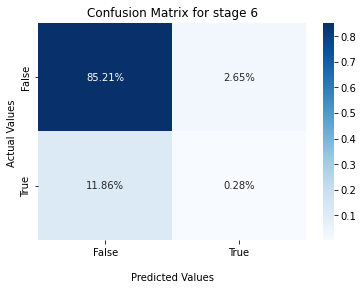

In [133]:
cm = confusion_matrix(label,label_6)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 6');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [134]:
time_label["pred_6"] = label_6

In [135]:
att_p6 = time_label[time_label['attack #'].isin([23])]

In [136]:
found = []
for i in range(len(att_p6)):
  if (att_p6.iloc[i]["pred_6"] == 1) & (att_p6.iloc[i]["label"] == 1):
    found.append(att_p6.iloc[i]["attack #"])
print(np.unique(found))

[23]


In [137]:
print(metrics.classification_report(att_p6.label,att_p6.pred_6))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.03      0.06       697

    accuracy                           0.03       697
   macro avg       0.50      0.02      0.03       697
weighted avg       1.00      0.03      0.06       697



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0   0]
 [674  23]]


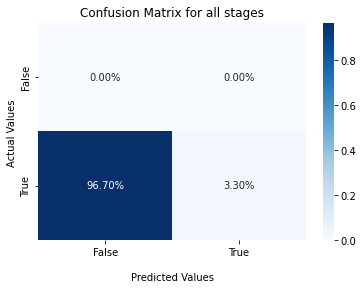

In [138]:
cm = confusion_matrix(att_p6.label,att_p6.pred_6)

print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for all stages');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

##Attack found

In [194]:
time_label['pred'] = np.where((time_label['pred_1'] ==1) | 
                              (time_label['pred_2'] ==1) |
                              (time_label['pred_3'] ==1) |
                              (time_label['pred_4'] ==1) |
                              (time_label['pred_5'] ==1) |
                              (time_label['pred_6'] ==1), 1, 0)


In [195]:
time_label[time_label["label"] == 1].tail(5)

,Timestamp,label,attack #,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred
445186,2016-02-01 13:41:07,1,0,0,0,1,0,0,0,1
445187,2016-02-01 13:41:08,1,0,0,0,1,0,0,0,1
445188,2016-02-01 13:41:09,1,0,0,0,1,0,0,0,1
445189,2016-02-01 13:41:10,1,0,0,0,1,0,0,0,1
445190,2016-02-01 13:41:11,1,0,0,0,1,0,0,0,1


In [196]:
found = []
for i in range(len(time_label)):
  if (time_label.iloc[i]["pred"] == 1) & (time_label.iloc[i]["label"] == 1):
    found.append(time_label.iloc[i]["attack #"])
print(np.unique(found))

[ 0  1  2  3  7  8 11 14 16 17 19 21 23 26 27 28 30 31 32 33 34 35 36 37
 38 41]


In [197]:
len(np.unique(found))-1 #remove 0

25

In [198]:
print(metrics.classification_report(time_label.label,time_label.pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92    395298
           1       0.41      0.43      0.42     54621

    accuracy                           0.85    449919
   macro avg       0.66      0.67      0.67    449919
weighted avg       0.86      0.85      0.86    449919



In [199]:
cm = confusion_matrix(time_label.label,time_label.pred)

print(cm)

[[360801  34497]
 [ 31110  23511]]


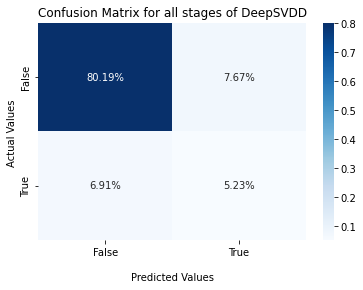

In [200]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for all stages of DeepSVDD');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()